In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import skeletonize
from skimage import measure
import matplotlib.pyplot as plt

# define seeds
np.random.seed(42)
torch.manual_seed(42)

## Step 1: Data Acquisition
### Here, I divide this step into two main tasks:
1. Explore DICOM images and their Metadata (Real CT images)
2. Generate synthetic data

#### Task 2: Synthetic CT series at two noise levels
The key idea is to define an image quality metric and see directionally if the approach is correct

In [2]:
# [h, w, n_slices]
input_shape = (128, 128, 30)

def generate_synthetic_vessel(noise_level=0.0, input_shape=(128, 128, 30)):
    volume = torch.zeros(input_shape)
    
    # define base
    center_base = torch.tensor([64, 64])
    radius = 10
    
    # use meshgrid for 'ij' indexing so that Y corresponds to rows and X corresponds to columns
    Y, X = torch.meshgrid(torch.arange(input_shape[0]),
                           torch.arange(input_shape[1]), indexing='ij')
    
    for z in range(input_shape[2]):
        shift_row = int(5 * np.sin(z / 3.0))
        shift_col = int(5 * np.cos(z / 3.0))
        shift = torch.tensor([shift_row, shift_col])
        
        center = center_base + shift
        
        # compute squared distance from each pixel to the center.
        dist2 = (Y - center[0])**2 + (X - center[1])**2
        
        # create a binary mask for the disk
        mask = dist2 <= radius**2
        
        volume[:, :, z] = mask.float()
    
    # add Guassian noise
    if noise_level > 0:
        noise = torch.normal(0, noise_level, size=input_shape)
        volume = volume + noise
        volume = torch.clamp(volume, 0, 1)
        
    return volume

phase1 = generate_synthetic_vessel(noise_level=0.05, input_shape=input_shape)
phase2 = generate_synthetic_vessel(noise_level=0.15, input_shape=input_shape)


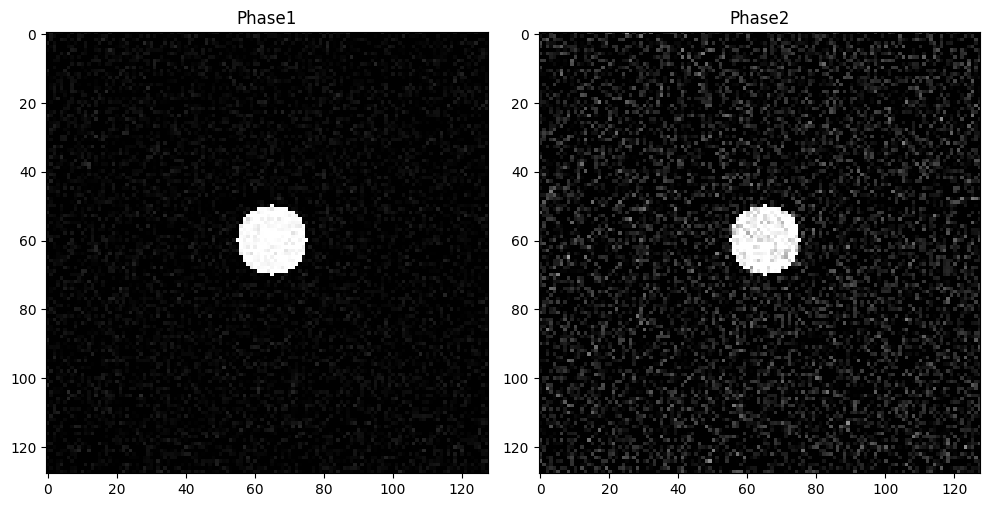

In [3]:
phase1.shape, phase2.shape
slice_idx = phase1.shape[2] // 2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(phase1.numpy()[:, :, slice_idx], cmap='gray')
axes[0].set_title("Phase1")

axes[1].imshow(phase2.numpy()[:, :, slice_idx], cmap='gray')
axes[1].set_title("Phase2")

plt.tight_layout()
plt.show()

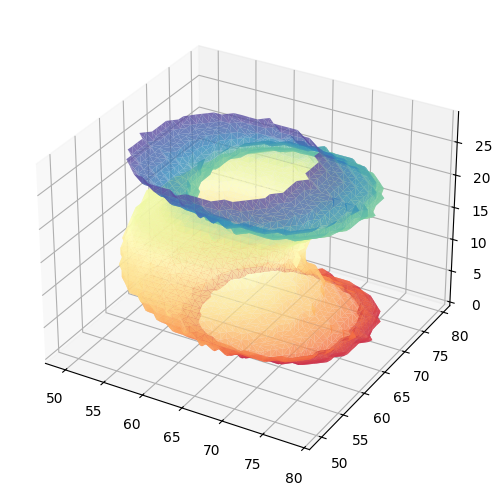

In [4]:

v, f, n, val = measure.marching_cubes(phase1.numpy(), level=0.5)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(v[:, 0], v[:, 1], f, v[:, 2],
                cmap='Spectral', lw=1, alpha=0.8)
plt.tight_layout()
plt.show()


In [5]:
class DummyIQNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        quality_score = self.fc(x)
        return quality_score

iq_model = DummyIQNet()

Phase1 quality score: 0.09313022394975026
Phase2 quality score: 0.09327062616745631
Selected best phase based on quality assessment.


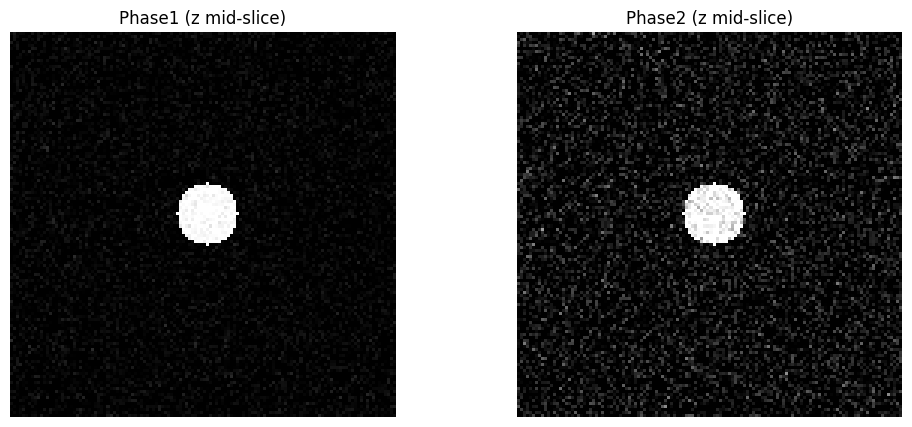

In [6]:
def assess_phase_quality(volume):
    """Compute the average quality score across all slices in a phase."""
    quality_scores = []
    for z in range(volume.shape[2]):
        slice_img = volume[:, :, z] 
        # Convert to tensor and replicate to 3 channels: shape (1, 3, 128, 128)
        slice_tensor = slice_img.unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).float()
        # Resize to 224x224 as required by the quality net.
        slice_tensor = F.interpolate(slice_tensor, size=(224, 224), mode='bilinear', align_corners=False)
        score = iq_model(slice_tensor)
        quality_scores.append(score.item())
    return np.mean(quality_scores)

phase1_quality = assess_phase_quality(phase1)
phase2_quality = assess_phase_quality(phase2)
print("Phase1 quality score:", phase1_quality)
print("Phase2 quality score:", phase2_quality)

# Select the best phase based on quality score.
best_phase = phase1 if phase1_quality >= phase2_quality else phase2
print("Selected best phase based on quality assessment.")

# For visualization, show one slice (mid z) from each phase.
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.imshow(phase1[:, :, input_shape[2]//2], cmap='gray')
plt.title("Phase1 (z mid-slice)")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(phase2[:, :, input_shape[2]//2], cmap='gray')
plt.title("Phase2 (z mid-slice)")
plt.axis('off')
plt.show()

In [7]:
class Dummy3DUNet(nn.Module):
    def __init__(self):
        super(Dummy3DUNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.out_conv = nn.Conv3d(16, 1, kernel_size=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.out_conv(x))
        return x

unet_model = Dummy3DUNet()

In [8]:
best_phase_reshape = best_phase.unsqueeze(0).unsqueeze(0).permute(0, 1, 4, 2, 3)
segmentations = unet_model(best_phase_reshape)
print("Segmentation output stats:")
print("Min:", segmentations.min().item())
print("Max:", segmentations.max().item())
print("Mean:", segmentations.mean().item())

Segmentation output stats:
Min: 0.4415567219257355
Max: 0.48849523067474365
Mean: 0.44910764694213867


In [9]:
binary_mask = (segmentations > 0.46).float().squeeze()
binary_mask[1,:, :].min()

tensor(0.)

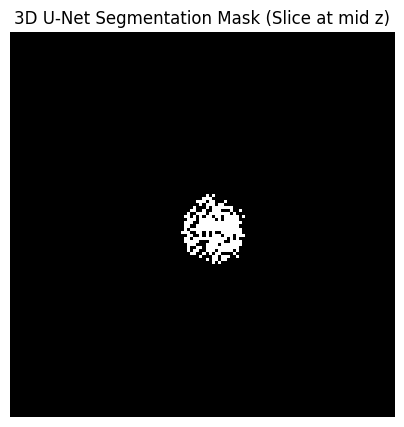

In [10]:
# Visualize one slice (mid z) of the segmentation mask.
plt.figure(figsize=(5,5))
plt.imshow(binary_mask[1, :, :], cmap='gray')
plt.title("3D U-Net Segmentation Mask (Slice at mid z)")
plt.axis('off')
plt.show()

In [27]:
skeleton_2d = np.zeros_like(binary_mask)
print(type(skeleton_2d))
for z in range(binary_mask.shape[0]):
    skeleton_2d[z, :, :] = skeletonize(binary_mask[z, :, :].numpy().astype(bool))

z, x, y = np.where(skeleton_2d > 0)
print(y.shape)

<class 'numpy.ndarray'>
(1823,)


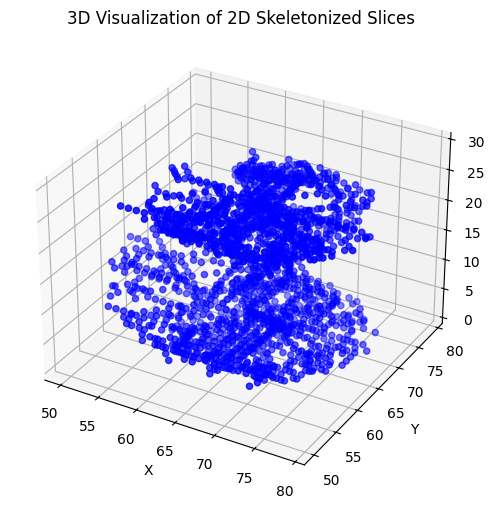

In [28]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue')
ax.set_title("3D Visualization of 2D Skeletonized Slices")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [29]:
target_z = input_shape[2] // 2
indices = np.where(skeleton_2d[0, :, :] > 0)
if indices[0].size > 0:
    center_y, center_x = int(indices[0][0]), int(indices[1][0])
else:
    center_y, center_x = 64, 64  # fallback
print("Selected centerline point at z =", 0, "at (x,y):", center_x, center_y)

Selected centerline point at z = 0 at (x,y): 64 64


torch.Size([128, 128])
(17, 33)
torch.Size([1, 64, 17, 33])


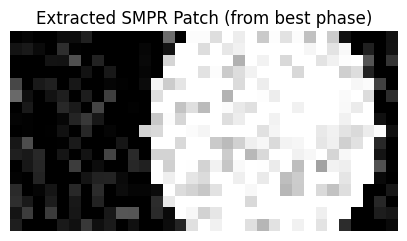

In [37]:
# Extract a cross-sectional patch (SMPR) from the best phase.
patch_h, patch_w = 17, 33
half_h, half_w = patch_h // 2, patch_w // 2

slice_img = best_phase[ :, :, 0]
print(slice_img.shape)
patch = slice_img[
    max(0, center_y - half_h):min(input_shape[0], center_y + half_h + 1),
    max(0, center_x - half_w):min(input_shape[1], center_x + half_w + 1)
]

# Pad patch if necessary (to ensure fixed patch size)
pad_h = patch_h - patch.shape[0]
pad_w = patch_w - patch.shape[1]
patch_padded = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
print(patch_padded.shape)
smpr_patch = np.stack([patch_padded] * 64, axis=0)  # shape: (64, patch_h, patch_w)
smpr_patch = torch.from_numpy(smpr_patch).unsqueeze(0).float()  # shape: (1,64,patch_h,patch_w)
print(smpr_patch.shape)
plt.figure(figsize=(5,5))
plt.imshow(patch_padded, cmap='gray')
plt.title("Extracted SMPR Patch (from best phase)")
plt.axis('off')
plt.show()

In [34]:
class DummyContourRegressor(nn.Module):
    def __init__(self, num_points=16):
        super(DummyContourRegressor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(32, num_points)  # Predict 16 radial distances.
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        points = self.fc(x)
        return points


In [35]:
regressor = DummyContourRegressor(num_points=16)
predicted_radii = regressor(smpr_patch).squeeze().detach().numpy()
print("Predicted radial distances (toy example):", predicted_radii)

Predicted radial distances (toy example): [ 0.11067853  0.00226886  0.14767955  0.12770249 -0.0280073  -0.10218055
  0.164923   -0.00839408 -0.0200709   0.1144201   0.01596614  0.1342188
 -0.13954052  0.02691628  0.21122113  0.02269167]


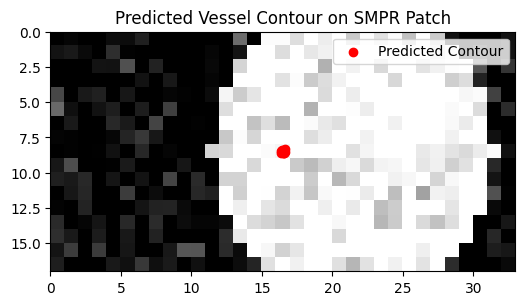

In [36]:
angles = np.linspace(0, 2 * np.pi, 16, endpoint=False)
center_patch = np.array([patch_w / 2, patch_h / 2])
# Compute contour points using the predicted radial distances.
contour_points = np.stack([predicted_radii * np.cos(angles),
                           predicted_radii * np.sin(angles)], axis=1)
contour_points += center_patch  # translate to patch center

plt.figure(figsize=(6,6))
plt.imshow(patch_padded, cmap='gray', extent=[0, patch_w, patch_h, 0])
plt.scatter(contour_points[:, 0], contour_points[:, 1], c='red', label='Predicted Contour')
# Connect the points to show a closed contour.
contour_points_closed = np.vstack([contour_points, contour_points[0]])
plt.plot(contour_points_closed[:, 0], contour_points_closed[:, 1], 'r--')
plt.title("Predicted Vessel Contour on SMPR Patch")
plt.legend()
plt.show()